## Разработка системы предупреждения аварий на каршеринге

**Описание и задача**

От каршеринговой компании поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея создания такой системы находится в стадии предварительного обсуждения и проработки. Чёткого алгоритма работы и подобных решений на рынке ещё не существует. Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Идея решения задачи от заказчика:** 

1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)

  - Для модели выбрать тип виновника — только машина (car).
  
  - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
  
  - Для моделирования ограничиться данными за 2012 год — они самые свежие.
  
  - Обязательное условие — учесть фактор возраста автомобиля.
  
  
2. На основе модели исследовать основные факторы ДТП.


3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:

  - Возможно ли создать адекватную систему оценки водительского риска при выдаче авто?
  
  - Какие ещё факторы нужно учесть?
  
  - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?
  

Заказчик предлагает вам поработать с базой данных по происшествиям и сформировать свои идеи создания такой системы. 

## Необходимые библиотеки

Выгрузим необходимые библиотеки.

In [169]:
!pip install phik -q
!pip install imblearn -q
!pip install catboost -q

In [170]:
from sqlalchemy import create_engine 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_columns', None)

## Подключитесь к базе. Загрузите таблицы sql

Напишем конфигурацию для подключения к базе данных data-science-vehicle-db, в которой содержатся таблицы, необходимые для работы.

In [171]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создаем подключение.

In [172]:
engine = create_engine(connection_string) 

**Вывод:**

Была написана конфигурация для подключения к базе данных data-science-vehicle-db, в которой содержатся таблицы, необходимые для работы, а также создано подключение.

## Проведите первичное исследование таблиц

Выгрузим первые 10 строк таблицы collisions — общая информация о ДТП.

In [173]:
query = '''
SELECT *
FROM collisions
LIMIT 10
'''

pd.read_sql_query(query, con=engine) 

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


Таблица collisions описывает общую информацию о ДТП. Например, где оно произошло и когда. Имеет уникальный case_id.

Описание данных:

- Идентификационный номер в базе данных	**CASE_ID** (уникальный номер для зарегистрированного происшествия в таблице происшествий)
- Номер географических районов, где произошло ДТП **COUNTY_CITY_LOCATION** (число)
- Названия географических районов, где произошло ДТП **COUNTY_LOCATION** (список разных названий, категориальный тип данных)
- Расстояние от главной дороги (метры) **DISTANCE**	(число)
- Направление движения	**DIRECTION**	
  - N — North (Север) 
  - E — East (Восток)
  - S — South (Юг)
  - W — West (Запад)
  - '-' or blank — Not stated (Не указано)
  - на перекрёстке
- Является ли место происшествие перекрёстком **INTERSECTION** 
  - Y — Intersection (перекрёсток)
  - N — Not Intersection (не перекрёсток)
  - '--' — Not stated (Не указано)
- Погода **WEATHER_1**
  - A — Clear (Ясно)
  - B — Cloudy (Облачно)
  - C — Raining (Дождь)
  - D — Snowing (Снегопад)
  - E — Fog (Туман)
  - F — Other (Другое)
  - G — Wind (Ветер)
  - '-' — Not Stated (Не указано)
- Тип дороги **LOCATION_TYPE**	
  - H — Highway (Шоссе)
  - I — Intersection (Перекрёсток)
  - R — Ramp (or Collector) (Рампа)
  - '-' or blank — Not Stated Highway (Не указано)
- Серьёзность происшествия **COLLISION_DAMAGE**	
  - 1 — FATAL ТС (Не подлежит восстановлению)
  - 2 — SEVERE DAMAGE (Серьёзный ремонт, большая часть под замену/Серьёзное повреждение капитального строения)
  - 3 — MIDDLE DAMAGE (Средний ремонт, машина в целом на ходу/Строение в целом устояло)
  - 4 — SMALL DAMAGE (Отдельный элемент кузова под замену/покраску)
  - 0 – SCRATCH (Царапина)
- Количество участников	**PARTY_COUNT**	(число)
- Основной фактор аварии **PRIMARY_COLL_FACTOR**	
  - A — Code Violation (Нарушение правил ПДД)
  - B — Other Improper Driving (Другое неправильное вождение)
  - C — Other Than Driver (Кроме водителя)
  - D — Unknown (Неизвестно)
  - E — Fell Asleep (Заснул)
  - '-' — Not Stated (Не указано)
- Категория нарушения **PCF_VIOLATION_CATEGORY**	
  - 01 — Driving or Bicycling Under the Influence of Alcohol or Drug (Вождение или езда на велосипеде в состоянии алкогольного или наркотического опьянения)
  - 02 — Impeding Traffic (Препятствие движению транспорта)
  - 03 — Unsafe Speed (Превышение скорости)
  - 04 — Following Too Closely (Опасное сближение)
  - 05 — Wrong Side of Road (Неправильная сторона дороги)
  - 06 — Improper Passing (Неправильное движение)
  - 07 — Unsafe Lane Change (Небезопасная смена полосы движения)
  - 08 — Improper Turning (Неправильный поворот)
  - 09 — Automobile Right of Way (Автомобильное право проезда)
  - 10 — Pedestrian Right of Way (Пешеходное право проезда)
  - 11 — Pedestrian Violation (Нарушение пешеходами)
  - 12 — Traffic Signals and Signs (Дорожные сигналы и знаки)
  - 13 — Hazardous Parking (Неправильная парковка)
  - 14 — Lights (Освещение)
  - 15 — Brakes (Тормоза)
  - 16 — Other Equipment (Другое оборудование)
  - 17 — Other Hazardous Violation (Другие нарушения)
  - 18 — Other Than Driver (or Pedestrian) (Кроме водителя или пешехода)
  - 19 — Speeding (Скорость)
  - 20 — Pedestrian dui (Нарушение пешехода)
  - 21 — Unsafe Starting or Backing (Опасный старт)
  - 22 — Other Improper Driving (Другое неправильное вождение)
  - 23 — Pedestrian or “Other” Under the Influence of Alcohol or Drug (Пешеход или «Другой» в состоянии алкогольного или наркотического опьянения)
  - 24 — Fell Asleep (Заснул)
  - 00 — Unknown (Неизвестно)
  - '-' — Not Stated (Не указано)
- Тип аварии **TYPE_OF_COLLISION**	
  - A — Head-On (Лоб в лоб)
  - B — Sideswipe (Сторона)
  - C — Rear End (Столкновение задней частью)
  - D — Broadside (Боковой удар)
  - E — Hit Object (Удар объекта)
  - F — Overturned (Опрокинутый)
  - G — Vehicle (транспортное средство/ Пешеход)
  - H — Other (Другое)
  - '-' — Not Stated (Не указано)
- Дополнительные участники ДТП **MOTOR_VEHICLE_INVOLVED_WITH**	
  - Other motor vehicle (Другой автомобиль)
  - Fixed object (Неподвижный объект)
  - Parked motor vehicle (Припаркованный автомобиль)
  - Pedestrian (Пешеход)
  - Bicycle (Велосипедист)
  - Non-collision (Не столкновение)
  - Other object (Другой объект)
  - Motor vehicle on other roadway (Автомобиль на другой проезжей)
  - Animal (Животное)
  - Train (Поезд)
- Состояние дороги **ROAD_SURFACE**	
  - A — Dry (Сухая)
  - B — Wet (Мокрая)
  - C — Snowy or Icy (Заснеженная или обледенелая)
  - D — Slippery (Muddy, Oily, etc.) (Скользкая, грязная, маслянистая и т. д.)
  - '-' — Not Stated (Не указано)
- Дорожное состояние	**ROAD_CONDITION_1**	
  - A — Holes, Deep Ruts (Ямы, глубокая колея)
  - B — Loose Material on Roadway (Сыпучий материал на проезжей части)
  - C — Obstruction on Roadway (Препятствие на проезжей части)
  - D — Construction or Repair Zone (Зона строительства или ремонта)
  - E — Reduced Roadway Width (Уменьшенная ширина проезжей части)
  - F — Flooded (Затоплено)
  - G — Other (Другое)
  - H — No Unusual Condition (Нет ничего необычного)
  - '-' — Not Stated (Не указано)
- Освещение	**LIGHTING**	
  - A — Daylight (Дневной свет)
  - B — Dusk-Dawn (Сумерки-Рассвет)
  - C — Dark-Street Lights (Темно-Уличные фонари)
  - D — Dark-No Street Lights (Темно-Нет уличных фонарей)
  - E — Dark-Street Lights Not Functioning (Темно-Уличные фонари не работают)
  - '-' — Not Stated (Не указано)
- Устройство управления	**CONTROL_DEVICE**	
  - A — Functioning (Функционирует)
  - B — Not Functioning (Не функционирует)
  - C — Obscured (Затемнённый)
  - D — None (Нет)
  - '-' — Not Stated (Не указано)
- Дата происшествия	**COLLISION_DATE** (формат год/месяц/день)
- Время происшествия **COLLISION_TIME** (формат: 24-часовой)

Выгрузим первые 10 строк таблицы parties — информация об участниках ДТП

In [174]:
query = '''
SELECT *
FROM Parties
LIMIT 10
'''

pd.read_sql_query(query, con=engine) 

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


Таблица parties имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

Описание данных:

- Индекс текущей таблицы **ID**	(номер в таблице)
- Идентификационный  номер в базе данных **CASE_ID** (уникальный номер для зарегистрированного происшествия в таблице происшествий)
- Номер участника происшествия **PARTY_NUMBER**	(от 1 до N — по числу участников происшествия)
- Тип участника происшествия **PARTY_TYPE**	
  - 1 — Car (Авто)
  - 2 — Road bumper (Отбойник)
  - 3 — Building (Строения)
  - 4 — Road signs (Дорожные знаки)
  - 5 — Other (Другое)
  - 6 — Operator (Оператор)
  - '-' — Not Stated (Не указано)
- Виновность участника	**AT_FAULT** (0/1)
- Сумма страховки (тыс. долларов) **INSURANCE_PREMIUM**	(число)
- Трезвость участника **PARTY_SOBRIETY**	
  - A — Had Not Been Drinking (Не пил)
  - B — Had Been Drinking, Under Influence (Был пьян, под влиянием)
  - C — Had Been Drinking, Not Under Influence (Был пьян, не под влиянием)
  - D — Had Been Drinking, Impairment Unknown (Был пьян, ухудшение неизвестно)
  - G — Impairment Unknown (Неизвестно ухудшение)
  - H — Not Applicable (Не оценивался)
  - '-' — Not Stated (Не указано)
- Состояние участника: физическое или с учётом принятых лекарств **PARTY_DRUG_PHYSICAL**	
  - E — Under Drug Influence (Под воздействием лекарств)
  - F — Impairment — Physical (Ухудшение состояния)
  - G — Impairment Unknown (Не известно)
  - H — Not Applicable (Не оценивался)
  - I — Sleepy/Fatigued (Сонный/Усталый)
  - '-' — Not Stated (Не указано)
- Наличие телефона в автомобиле (возможности разговаривать по громкой связи) **CELLPHONE_IN_USE** (0/1)

Выгрузим первые 10 строк таблицы vehicles — информация о пострадавших машинах.

In [175]:
query = '''
SELECT *
FROM Vehicles
LIMIT 10
'''

pd.read_sql_query(query, con=engine) 

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


Таблица vehicles имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

- Индекс текущей таблицы **ID**	(номер в таблице)
- Идентификационный номер в базе данных	**CASE_ID**	(уникальный номер для зарегистрированного происшествия в таблице происшествий)
- Номер участника происшествия **PARTY_NUMBER**	(от 1 до N — по числу участников происшествия)
- Тип кузова **VEHICLE_TYPE**	
  - MINIVAN
  - COUPE
  - SEDAN
  - HATCHBACK
  - OTHER
- Тип КПП **VEHICLE_TRANSMISSION**	
  - auto (Автоматическая)
  - manual (Ручная)
  - '-' — Not Stated (Не указано)
- Возраст автомобиля (в годах)	**VEHICLE_AGE**	(число)

**Вывод:**

Были выгружены таблицы collisions, parties, vehicles.

- Все таблицы имеют набор данных, соответсвующий приведенному описанию.
- Количество таблиц соответсвует заявленному.
- Общим ключом для связи является case_id и он имеется во всех таблицах.


##  Проведите статистический анализ факторов ДТП

Посмотрим на данные по количеству аварий в каждый месяц каждого года, чтобы понимать их распределение.

In [176]:
query = """

SELECT DATE_TRUNC('MONTH', collision_date)::date as month,
       COUNT(case_id) as collisions_count
FROM collisions
GROUP BY month;

"""

pd.read_sql_query(query, con = engine).sort_values(by='month')

,month,collisions_count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


Выясним, в какие месяцы происходит наибольшее количество аварий в период с 2009 года по 2012-06-01, т.к. в другое время очень мало наблюдений.

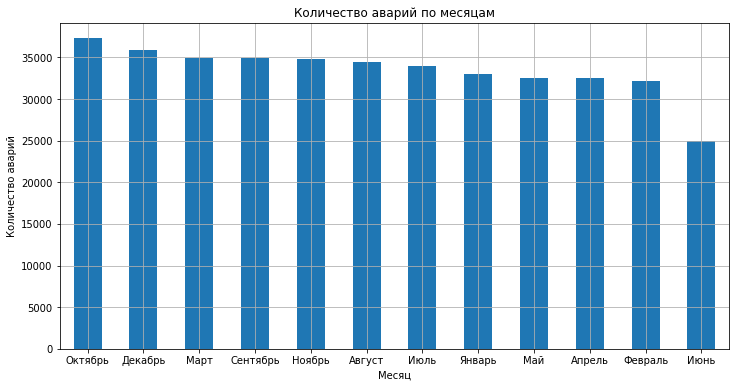

In [177]:
query = '''

WITH help AS
(SELECT DATE_TRUNC('MONTH', collision_date)::date AS collisions_date, 
       count(case_id) AS collisions_count
FROM collisions
WHERE collision_date BETWEEN '2009-01-01' AND '2012-06-01'
GROUP BY collisions_date)

SELECT EXTRACT(MONTH FROM collisions_date) AS month,
    AVG(collisions_count) AS collisions_avg
FROM help
GROUP BY month
'''

collisions_count = pd.read_sql_query(query, con=engine)

month =  {1 : 'Январь',
          2 : 'Февраль',
          3 : 'Март',
          4 : 'Апрель',
          5 : 'Май',
          6 : 'Июнь',
          7 : 'Июль',
          8 : 'Август',
          9 : 'Сентябрь',
          10 : 'Октябрь',
          11 : 'Ноябрь',
          12 : 'Декабрь'} 

collisions_count['month'] = collisions_count['month'].replace(month)

collisions_count.sort_values(by='collisions_avg', ascending=False).plot(x='month',
                                                                          y='collisions_avg',
                                                                          kind='bar',
                                                                          grid=True,
                                                                          legend=False,
                                                                          rot=0,
                                                                          figsize=(12,6));
plt.title('Количество аварий по месяцам');
plt.xlabel('Месяц');
plt.ylabel('Количество аварий');

Самое большое количество аварий происходит в октябре, декабре и марте (вероятнее всего это происходит из-за сложных погодных условий). Меньше всего аварий происходит в июне.

Аналитические задачи для рабочей группы:

- Определить количество аварий в зависимости от времени суток и освещенности дороги (collisions).
- Определить самую аварийно-опасную погоду (collisions).
- Провести анализ серьезности происшествия в зависимости от погодных условий и состояния дороги (collisions).
- Определить количество аварий в зависимости от географического района (collisions).
- Определить количество аварий в зависимости от типа дороги (collisions).
- Провести анализ количества участников ДТП в зависимости от погодных условий и состояния дороги (collisions).
- Определить какой тип нарушения ПДД приводит чаще всего к ДТП (collisions).
- Определить тип аварии в зависимости от типа дороги (collisions).
- Определить самый часто встречающийся тип участника ДТП (parties).
- Определить разброс количества участников ДТП (parties). 
- Провести анализ серьезности происшествия в зависимости от состояния и трезвости водителя (collisions и parties).
- Провести анализ зависимости причины аварии от состояния и трезвости водителя (collisions и parties).
- Определить влияние наличия телефона в автомобиле на тип аварии (collisions и parties).
- Провести анализ серьезности происшествия в зависимости от возраста автомобиля (collisions и vehicles).

### Пример решения задач для рабочей группы

Определим влияние наличия телефона в автомобиле на тип аварии.

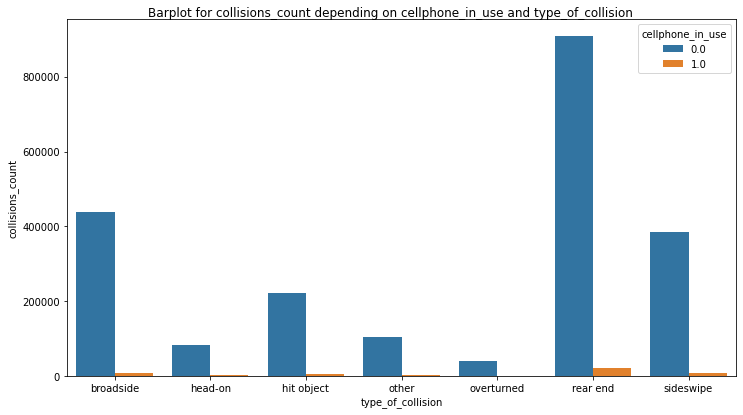

In [178]:
query = '''
SELECT c.type_of_collision,
       p.cellphone_in_use,
       COUNT(c.case_id) AS collisions_count
FROM collisions AS c 
JOIN parties AS p ON c.case_id=p.case_id
GROUP BY c.type_of_collision, p.cellphone_in_use
'''

collisions_count = pd.read_sql_query(query, con=engine)

sns.barplot(data=collisions_count, 
                 x='type_of_collision',
                 y='collisions_count',
                 hue='cellphone_in_use');
plt.gcf().set_size_inches(12,6);
plt.subplots_adjust(top=.95);
plt.suptitle('Barplot for collisions_count depending on cellphone_in_use and type_of_collision');

Автомобили как со встроенным телефоном, так и без него чаще всего поподают в аварии типа "столкновение задней частью".

Посмотрим отдельно статистику влияние наличия телефона в автомобиле на тип аварии только для виновников аварии.

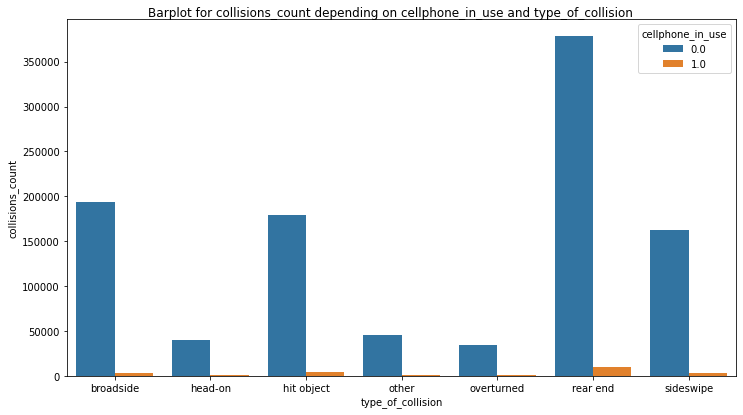

In [179]:
query = '''
SELECT c.type_of_collision,
       p.cellphone_in_use,
       COUNT(c.case_id) AS collisions_count
FROM collisions AS c 
JOIN parties AS p ON c.case_id=p.case_id
WHERE p.at_fault = 1
GROUP BY c.type_of_collision, p.cellphone_in_use
'''

collisions_count = pd.read_sql_query(query, con=engine)

sns.barplot(data=collisions_count, 
                 x='type_of_collision',
                 y='collisions_count',
                 hue='cellphone_in_use');
plt.gcf().set_size_inches(12,6);
plt.subplots_adjust(top=.95);
plt.suptitle('Barplot for collisions_count depending on cellphone_in_use and type_of_collision');

Виновники аварии чаще всего не имеют встроенного телефона в машине, а это значит, что они могут пользоваться телефоном в руке и отвлекаться от дороги, что повышает аварийность.

Проведем анализ зависимости тяжести аварии от возраста автомобиля.

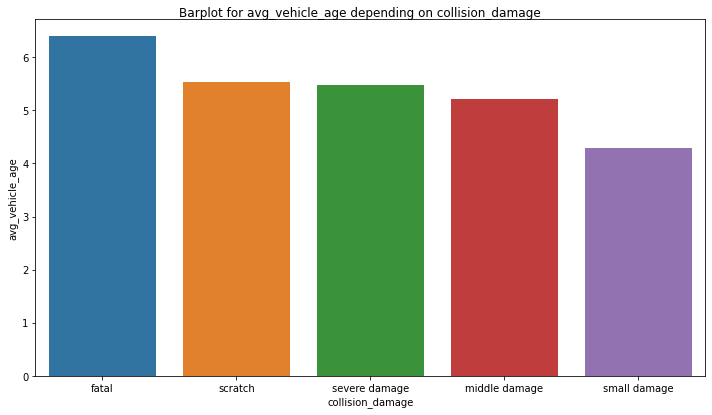

In [180]:
query = '''
SELECT c.collision_damage,
       AVG(v.vehicle_age) AS avg_vehicle_age
FROM collisions AS c 
JOIN vehicles AS v ON c.case_id=v.case_id
GROUP BY c.collision_damage
'''

avg_vehicle_age = pd.read_sql_query(query, con=engine).sort_values(by='avg_vehicle_age', ascending=False)

sns.barplot(data=avg_vehicle_age, 
                 x='collision_damage', 
                 y='avg_vehicle_age');
plt.gcf().set_size_inches(12,6);
plt.subplots_adjust(top=.95);
plt.suptitle('Barplot for avg_vehicle_age depending on collision_damage');

Чем старше автомобиль, тем повреждения, нанесенные в аварии, опаснее.

**Вывод:**

Были подготовлены задачи для рабочей группы:

- Выяснить в какой месяц чаще всего происходят аварии.
- Определить количество аварий в зависимости от времени суток и освещенности дороги (collisions).
- Определить самую аварийно-опасную погоду (collisions).
- Провести анализ серьезности происшествия в зависимости от погодных условий и состояния дороги (collisions).
- Определить количество аварий в зависимости от географического района (collisions).
- Определить количество аварий в зависимости от типа дороги (collisions).
- Провести анализ количества участников ДТП в зависимости от погодных условий и состояния дороги (collisions).
- Определить какой тип нарушения ПДД приводит чаще всего к ДТП (collisions).
- Определить тип аварии в зависимости от типа дороги (collisions).
- Определить самый часто встречающийся тип участника ДТП (parties).
- Определить разброс количества участников ДТП (parties). 
- Провести анализ серьезности происшествия в зависимости от состояния и трезвости водителя (collisions и parties).
- Провести анализ зависимости причины аварии от состояния и трезвости водителя (collisions и parties).
- Определить влияние наличия телефона в автомобиле на тип аварии (collisions и parties).
- Провести анализ серьезности происшествия в зависимости от возраста автомобиля (collisions и vehicles).

Некоторые из пунктов были проверены:

- Самое большое количество аварий происходит в октябре, декабре и марте (вероятнее всего это происходит из-за сложных погодных условий). Меньше всего аварий происходит в июне.
- Автомобили как со встроенным телефоном, так и без него чаще всего поподают в аварии типа "столкновение задней частью". Виновники аварии чаще всего не имеют встроенного телефона в машине, а это значит, что они могут пользоваться телефоном в руке и отвлекаться от дороги, что повышает аварийность.
- Чем старше автомобиль, тем повреждения, нанесенные в аварии, опаснее.

## Создайте модель для оценки водительского риска

### Выгрузка данных для модели

Выгрузим данные из таблиц, при следующих условиях:

- Для модели выбрать тип виновника — только машина (car).
  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
  
- Для моделирования ограничиться данными за 2012 год — они самые свежие.
  
- Обязательное условие — учесть фактор возраста автомобиля.

In [181]:
query = '''
SELECT ROW_NUMBER() OVER () as id,
       c.case_id,
       p.party_number,
       c.county_location,
       c.weather_1 AS weather,
       c.road_surface,
       c.lighting,
       c.control_device,
       EXTRACT(MONTH FROM c.collision_date::timestamp) AS month,
       EXTRACT(HOUR FROM c.collision_time) AS time,
       p.at_fault, 
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age       
  FROM collisions AS c
  JOIN parties AS p ON c.case_id = p.case_id
  JOIN vehicles AS v ON c.case_id = v.case_id AND p.party_number = v.party_number
   WHERE p.party_type = 'car'
       AND c.collision_damage != 'scratch'
       AND c.collision_date BETWEEN '2012-01-01' AND '2012-12-31';
'''
data = pd.read_sql_query(query, con=engine)

In [182]:
data

,id,case_id,party_number,county_location,weather,road_surface,lighting,control_device,month,time,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,1,5448788,1,el dorado,clear,dry,daylight,functioning,1.0,16.0,0,25.0,had not been drinking,None,0.0,sedan,manual,4.0
1,2,5403312,1,san diego,clear,dry,daylight,none,1.0,12.0,1,86.0,had not been drinking,None,0.0,coupe,auto,13.0
2,3,5403341,2,los angeles,clear,dry,daylight,none,1.0,10.0,0,53.0,had not been drinking,None,0.0,sedan,manual,3.0
3,4,5403344,1,los angeles,clear,dry,daylight,none,1.0,13.0,1,72.0,had not been drinking,None,0.0,coupe,auto,11.0
4,5,5403431,1,alameda,clear,dry,dark with street lights,none,1.0,18.0,1,43.0,"had been drinking, under influence",None,NaN,coupe,manual,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,56244,5454027,2,orange,clear,wet,dark with street lights,none,1.0,21.0,0,56.0,had not been drinking,None,0.0,sedan,auto,12.0
56244,56245,5454033,1,san diego,clear,dry,daylight,none,1.0,11.0,1,38.0,had not been drinking,None,0.0,sedan,auto,1.0
56245,56246,5454033,2,san diego,clear,dry,daylight,none,1.0,11.0,0,25.0,had not been drinking,None,0.0,sedan,auto,3.0
56246,56247,5454034,1,riverside,clear,dry,daylight,none,1.0,16.0,1,36.0,had not been drinking,None,0.0,coupe,manual,5.0


**Вывод:**

Были выгружены данные из таблиц collisions, parties и vehicles при следующих условиях:

- Тип виновника — только машина (car).  
- ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина). 
- Данные выбраны только за 2012 год.

### Предобработка

Поверим столбцы на соответствие их значений приведенному описанию и на наличие аномалий.

In [183]:
for c in data.columns:
    if len(data[c].unique()) < 100:
        print(c + ' :')
        print(data[c].sort_values().unique())
        print()

party_number :
[1 2 3 4 5 6 7 8 9]

county_location :
['alameda' 'alpine' 'amador' 'butte' 'calaveras' 'colusa' 'contra costa'
 'del norte' 'el dorado' 'fresno' 'glenn' 'humboldt' 'imperial' 'inyo'
 'kern' 'kings' 'lake' 'lassen' 'los angeles' 'madera' 'marin' 'mariposa'
 'mendocino' 'merced' 'modoc' 'mono' 'monterey' 'napa' 'nevada' 'orange'
 'placer' 'plumas' 'riverside' 'sacramento' 'san benito' 'san bernardino'
 'san diego' 'san francisco' 'san joaquin' 'san luis obispo' 'san mateo'
 'santa barbara' 'santa clara' 'santa cruz' 'shasta' 'sierra' 'siskiyou'
 'solano' 'sonoma' 'stanislaus' 'sutter' 'tehama' 'trinity' 'tulare'
 'tuolumne' 'ventura' 'yolo' 'yuba']

weather :
['clear' 'cloudy' 'fog' 'other' 'raining' 'snowing' 'wind' None]

road_surface :
['dry' 'slippery' 'snowy' 'wet' None]

lighting :
['dark with no street lights' 'dark with street lights'
 'dark with street lights not functioning' 'daylight' 'dusk or dawn' None]

control_device :
['functioning' 'none' 'not functioning

- В многих столбцах имеются пропуски. 
- В столбце party_drug_physical можно заменить значение G на расшифровку.
- В в столбце vehicle_age имеются аномалии, аномалии и выбросы подробнее будут изучены далее.

Проверим столбцы на наличие пропусков.

In [184]:
data.isna().sum()

id                          0
case_id                     0
party_number                0
county_location             0
weather                   168
road_surface              348
lighting                  154
control_device            215
month                       0
time                       88
at_fault                    0
insurance_premium         547
party_sobriety            872
party_drug_physical     53391
cellphone_in_use         4471
vehicle_type                0
vehicle_transmission      859
vehicle_age              1694
dtype: int64

Пропуски по приведенному описанию данных для категориальных столбцов ''weather', 'road_surface', 'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'vehicle_transmission' соотвествуют значению 'not_stated'. Заменим все пропуски в этих столбцах на 'not_stated'. Пропуски в столбце 'cellphone_in_use' заменим на 0.

In [185]:
columns = ['weather', 'road_surface', 'lighting', 'control_device', 
           'party_sobriety', 'party_drug_physical', 'vehicle_transmission']
data[columns] = data[columns].fillna('not_stated')
data['cellphone_in_use'].fillna(0, inplace=True)          

Удалим пропуски в численных столбцах 'time', 'insurance_premium' и 'vehicle_age'.

In [186]:
columns = ['time', 'insurance_premium', 'vehicle_age']
data.dropna(subset=columns, inplace=True)

Проверим количество пропусков.

In [187]:
data.isna().sum()

id                      0
case_id                 0
party_number            0
county_location         0
weather                 0
road_surface            0
lighting                0
control_device          0
month                   0
time                    0
at_fault                0
insurance_premium       0
party_sobriety          0
party_drug_physical     0
cellphone_in_use        0
vehicle_type            0
vehicle_transmission    0
vehicle_age             0
dtype: int64

В столбце party_drug_physical заменим значение G на расшифровку - impairment unknown.

In [188]:
data['party_drug_physical'].replace('G', 'impairment unknown', inplace=True)
data['party_drug_physical'].unique()

array(['not_stated', 'under drug influence', 'sleepy/fatigued',
       'impairment unknown', 'not applicable', 'impairment - physical'],
      dtype=object)

Проверим типы данных в датасете.

In [189]:
data.dtypes

id                        int64
case_id                  object
party_number              int64
county_location          object
weather                  object
road_surface             object
lighting                 object
control_device           object
month                   float64
time                    float64
at_fault                  int64
insurance_premium       float64
party_sobriety           object
party_drug_physical      object
cellphone_in_use        float64
vehicle_type             object
vehicle_transmission     object
vehicle_age             float64
dtype: object

Заменим типы столбцов 'case_id', 'month', 'time', 'insurance_premium' и 'vehicle_age' на целочисленный. 

In [190]:
columns = ['case_id', 'month', 'time', 'insurance_premium', 'vehicle_age','cellphone_in_use']
data[columns] =  data[columns].astype('int')
data.dtypes

id                       int64
case_id                  int64
party_number             int64
county_location         object
weather                 object
road_surface            object
lighting                object
control_device          object
month                    int64
time                     int64
at_fault                 int64
insurance_premium        int64
party_sobriety          object
party_drug_physical     object
cellphone_in_use         int64
vehicle_type            object
vehicle_transmission    object
vehicle_age              int64
dtype: object

Проверим столбцы на выбросы и аномалии.

In [191]:
data.describe()

,id,case_id,party_number,month,time,at_fault,insurance_premium,cellphone_in_use,vehicle_age
count,54052.000000,5.405200e+04,54052.000000,54052.000000,54052.000000,54052.000000,54052.000000,54052.000000,54052.000000
mean,28139.212314,5.561606e+06,1.530452,3.237882,13.311589,0.502331,37.625916,0.018778,4.861485
std,16237.671954,5.878676e+04,0.665002,1.809779,5.513861,0.499999,16.348461,0.135742,3.239812
min,1.000000,5.125160e+06,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14092.750000,5.514769e+06,1.000000,2.000000,10.000000,0.000000,24.000000,0.000000,3.000000
50%,28131.500000,5.558986e+06,1.000000,3.000000,14.000000,1.000000,34.000000,0.000000,4.000000
75%,42218.250000,5.613300e+06,2.000000,4.000000,17.000000,1.000000,49.000000,0.000000,7.000000
max,56248.000000,5.668356e+06,9.000000,12.000000,23.000000,1.000000,105.000000,1.000000,161.000000


В столбцах 'vehicle_age' явно встречаются аномалии, изучим их. Выбросы не были выявлены.

Получим количество выбросов.

In [192]:
print('vehicle_age')
sum_outliers = (data['vehicle_age'] > 19).sum()
print(f'Количество выбросов {sum_outliers}')

vehicle_age
Количество выбросов 2


Удалим выбросы.

In [193]:
data = data.query('vehicle_age <= 19')

Проверим количество дубликатов.

In [194]:
data.drop(['id', 'case_id', 'party_number'], axis=1).duplicated().sum()

559

Удалим дубликаты.

In [195]:
data = data.drop_duplicates(data.drop(['id', 'case_id', 'party_number'], axis=1).columns)

data.drop(['id', 'case_id', 'party_number'], axis=1).duplicated().sum()

0

**Вывод:**

- Были выявлены пропуски в данных:
  - Пропуски по приведенному описанию данных для категориальных столбцов 'weather', 'road_surface', 'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'vehicle_transmission' соотвествуют значению 'not_stated'. Были заменены все пропуски в этих столбцах на 'not_stated'.
  - Пропуски в численном столбце 'cellphone_in_use' были заменены на 0.
  - Пропуски в численных столбцах 'time', 'insurance_premium' и 'vehicle_age' были удалены.
- В столбце party_drug_physical заменили значение G на расшифровку - impairment unknown.
- Заменили типы столбцов 'case_id', 'month', 'time', 'insurance_premium' и 'vehicle_age'' на целочисленный.
- В столбце 'vehicle_age' встречались аномалии, они были удалены. Выбросы выявлены не были.
- Неявных дубликатов не было найдено, а явные были выявлены и удалены.

### Исследовательский анализ

Построим гистограммы для признаков из таблицы collisions.

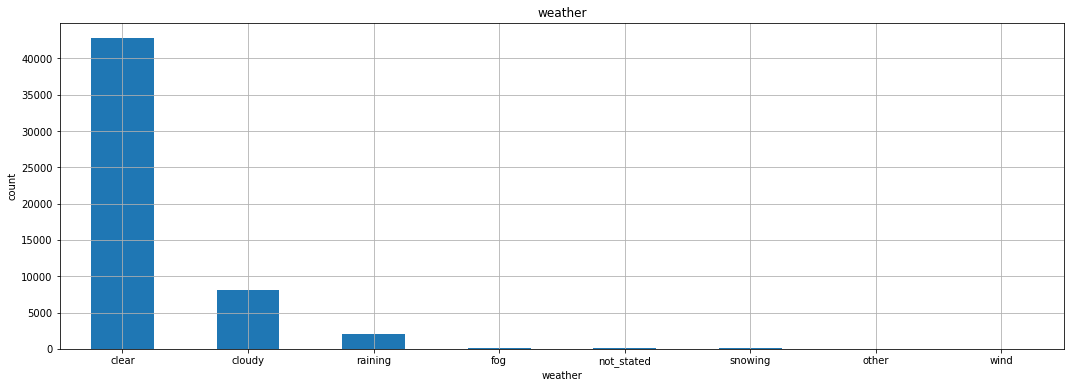

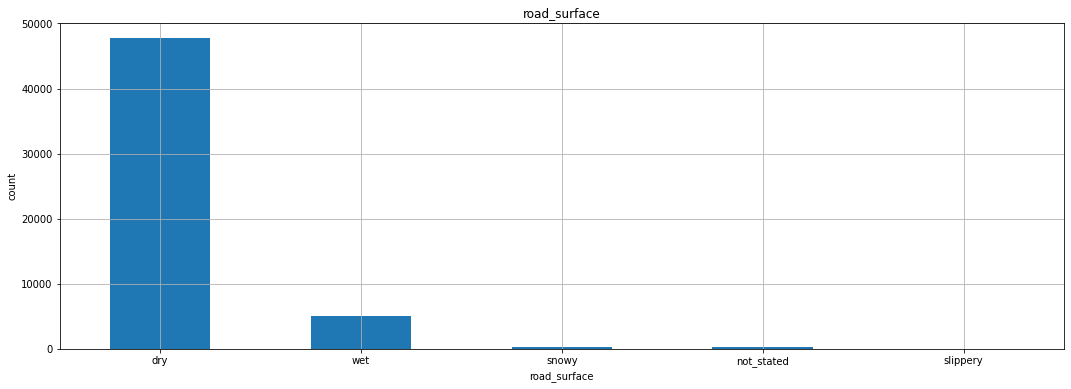

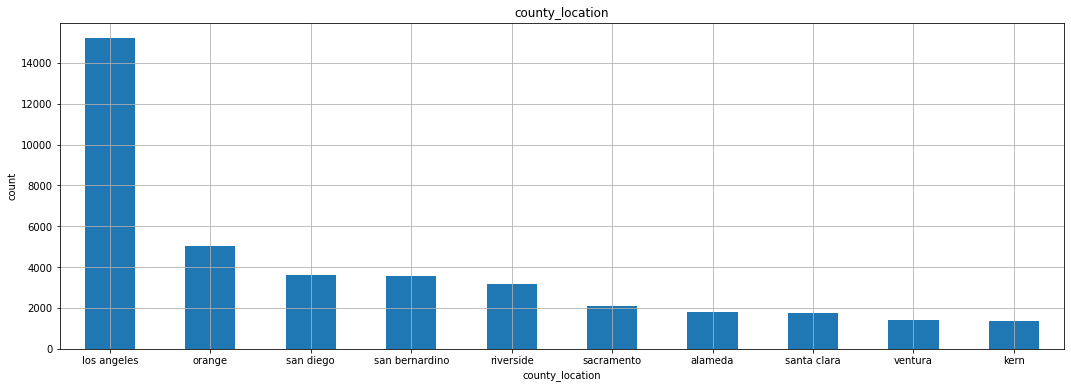

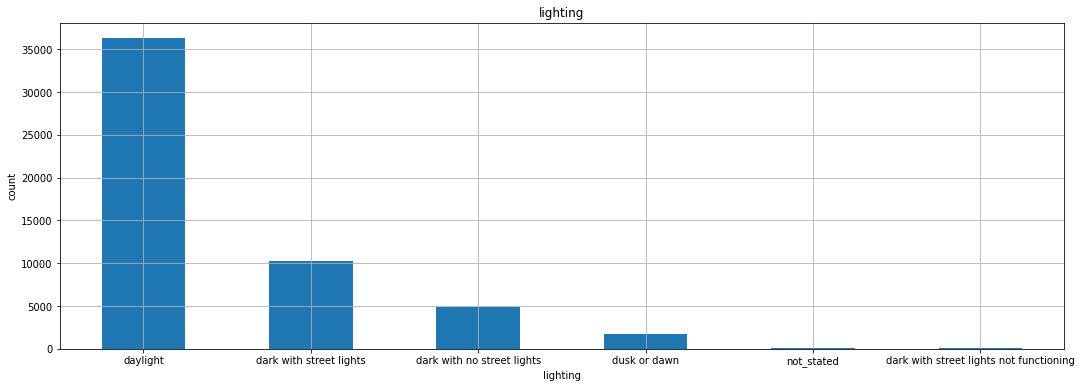

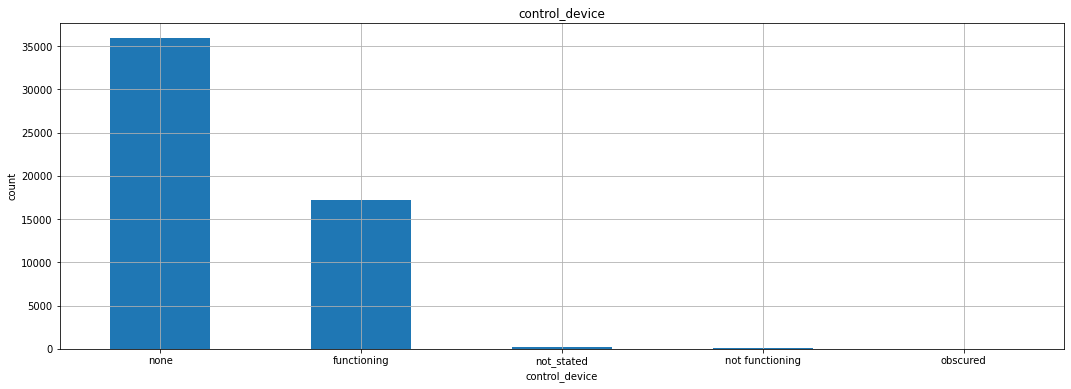

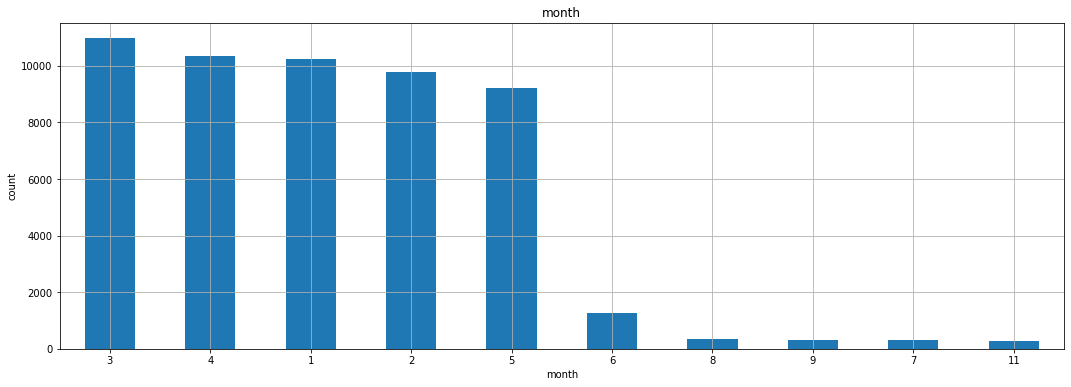

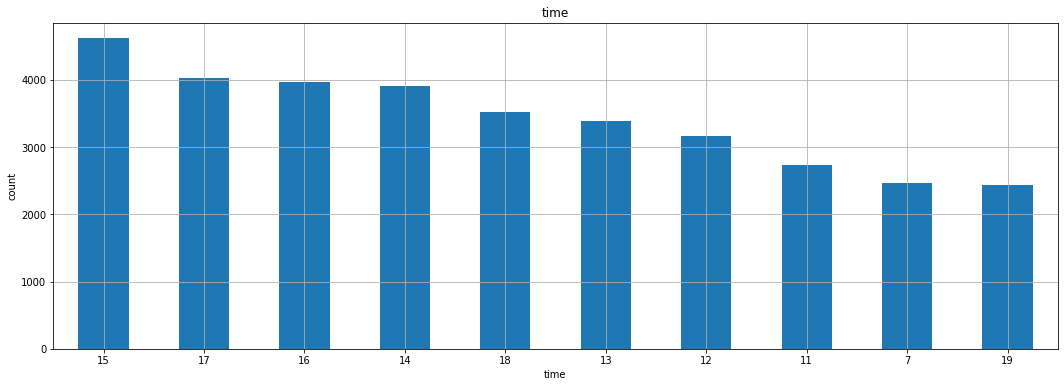

In [196]:
columns = ['weather', 'road_surface', 'county_location',
       'lighting', 'control_device', 'month', 'time']
for c in columns:
    data.groupby(c)[c].count().sort_values(ascending=False)[0:10].plot(kind='bar', 
                                                                       figsize=(18,6), 
                                                                       grid=True, 
                                                                       rot=0,
                                                                       xlabel=c,
                                                                       ylabel='count',
                                                                       title=c)
    plt.show();

- В ясную погоду происходит больше всего аварий (вероятно, потому что в этих географических районах ясных дней больше всего).
- Больше всего аварий в сухую погоду (вероятно, потому что в этих географических районах ясных дней больше всего).
- Чаще всего аварии происходят при дневном свете (так как днем больше всего участников дорожного движения).
- Чаще всего попадают в ДТП автомобили, не оснащенные устройствами помощи водителю.
- Зимние и весенние месяцы наиболее аварийно-опасные (из-за нестабильных климатических условий и их последствий).
- Пик аварийности приходится на промежуток 14.00-18.00.
- Лос-Анджелес - самый аварийный город.

Построим гистограммы для признаков из таблицы parties и vehicles в зависимости от целевого признака 'at_fault', предварительно создав функцию.

In [197]:
def func_plot(data, c, type_plot, figsize=(18,6)):
    data.pivot_table('id', c, 'at_fault', aggfunc='count').plot(kind=type_plot, 
                                                                 figsize=figsize, 
                                                                 grid=True, 
                                                                 rot=0,
                                                                 xlabel=c,
                                                                 ylabel='count',
                                                                 title=c)
    plt.show();

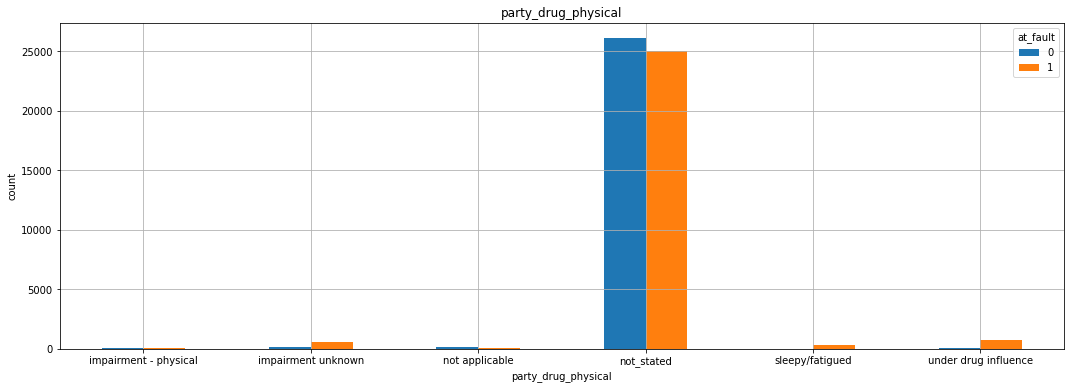

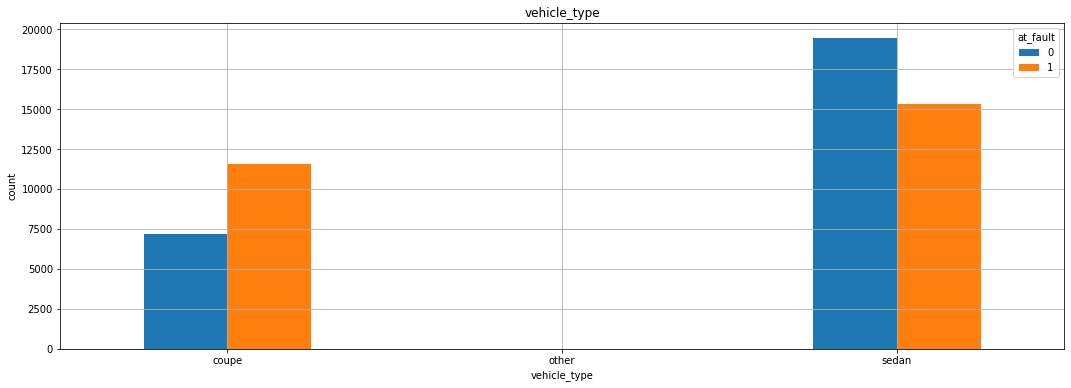

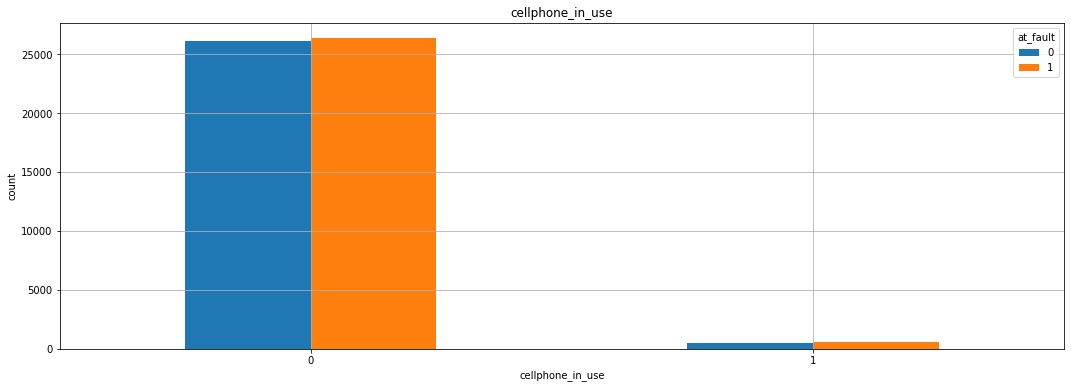

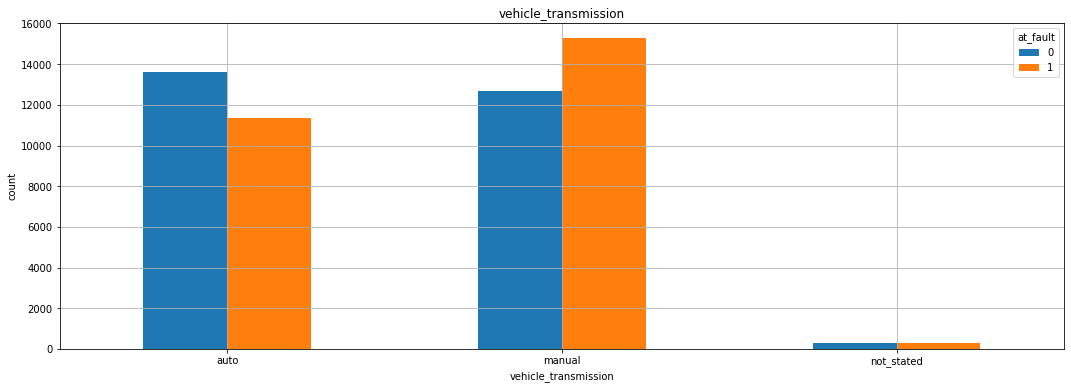

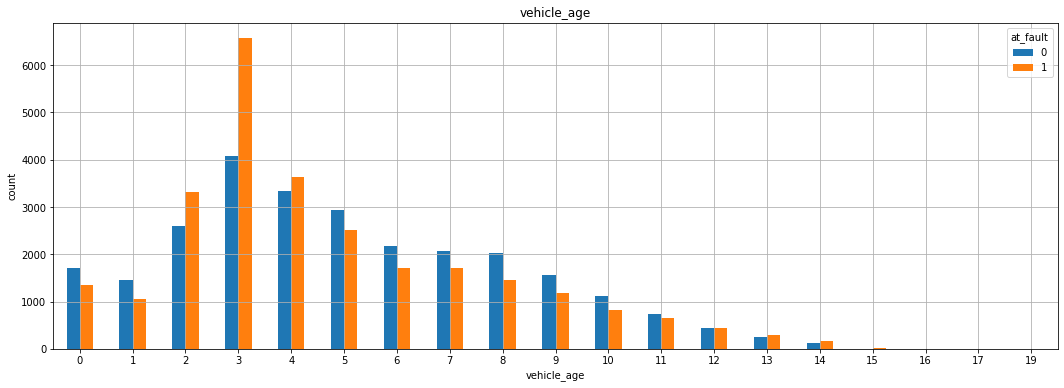

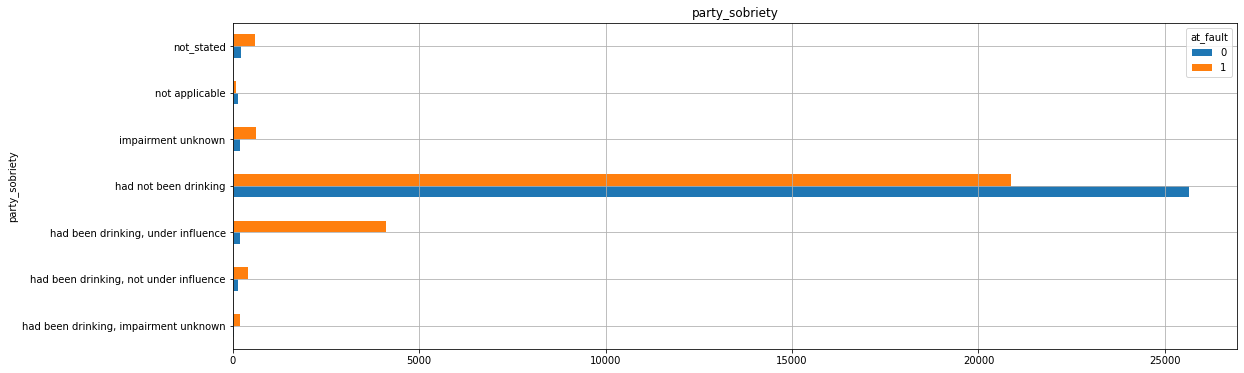

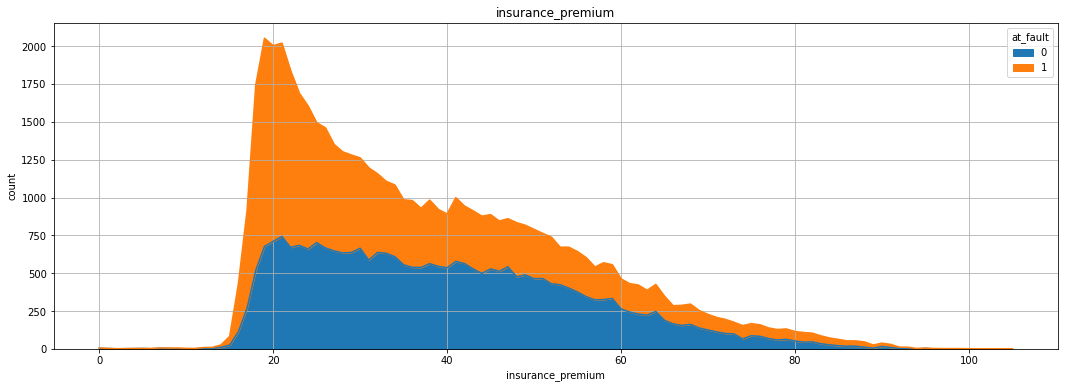

In [198]:
columns = ['party_drug_physical', 'vehicle_type', 'cellphone_in_use', 
           'vehicle_transmission', 'vehicle_age']
for c in columns:
    func_plot(data, c, 'bar')
    plt.show();   
func_plot(data, 'party_sobriety', 'barh')
func_plot(data, 'insurance_premium', 'area')

- Невыпившие водители чаще всего попадают в аварии, так как их больше всего на дорогах. Выпившие водители чаще всего становятся виновниками аварии.
- Водители под влиянием веществ чаще всего становятся виновниками аварии.
- Чаще всего водители попадают в аварии на седанах. Виновниками аварии чаще становятся водители купе в процентном соотношении от всех владельцев купе, владельцы седанов - более аккуратны.
- Автоматическая трансмиссия более безопасна.
- Чем больше страховка, тем аккуратнее водит автомобилист.
- Чем старше машина, тем аккуратнее водит водитель.

Проверим баланс целевого признака.

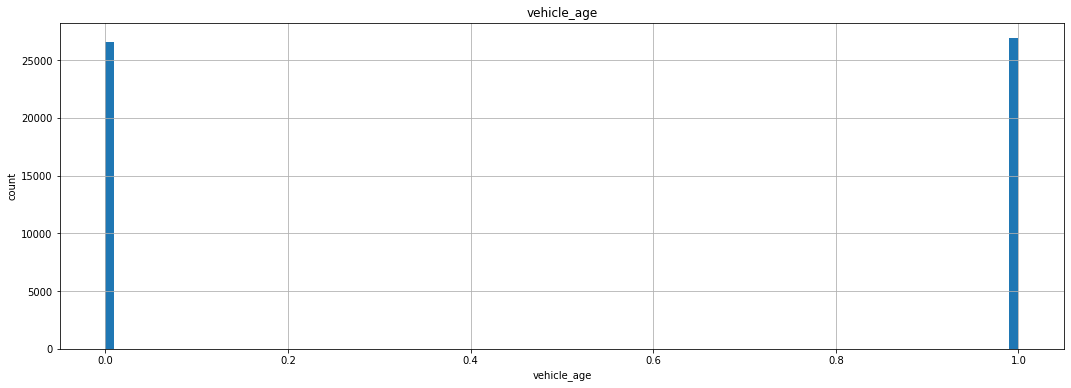

In [199]:
data['at_fault'].hist(bins=100, figsize=(18,6));
plt.title(c);
plt.xlabel(c);
plt.ylabel('count');
plt.show();

Целевой признак сбалансирован.

Построим матрицу корреляции для всех признаков.

interval columns not set, guessing: ['month', 'time', 'at_fault', 'insurance_premium', 'cellphone_in_use', 'vehicle_age']


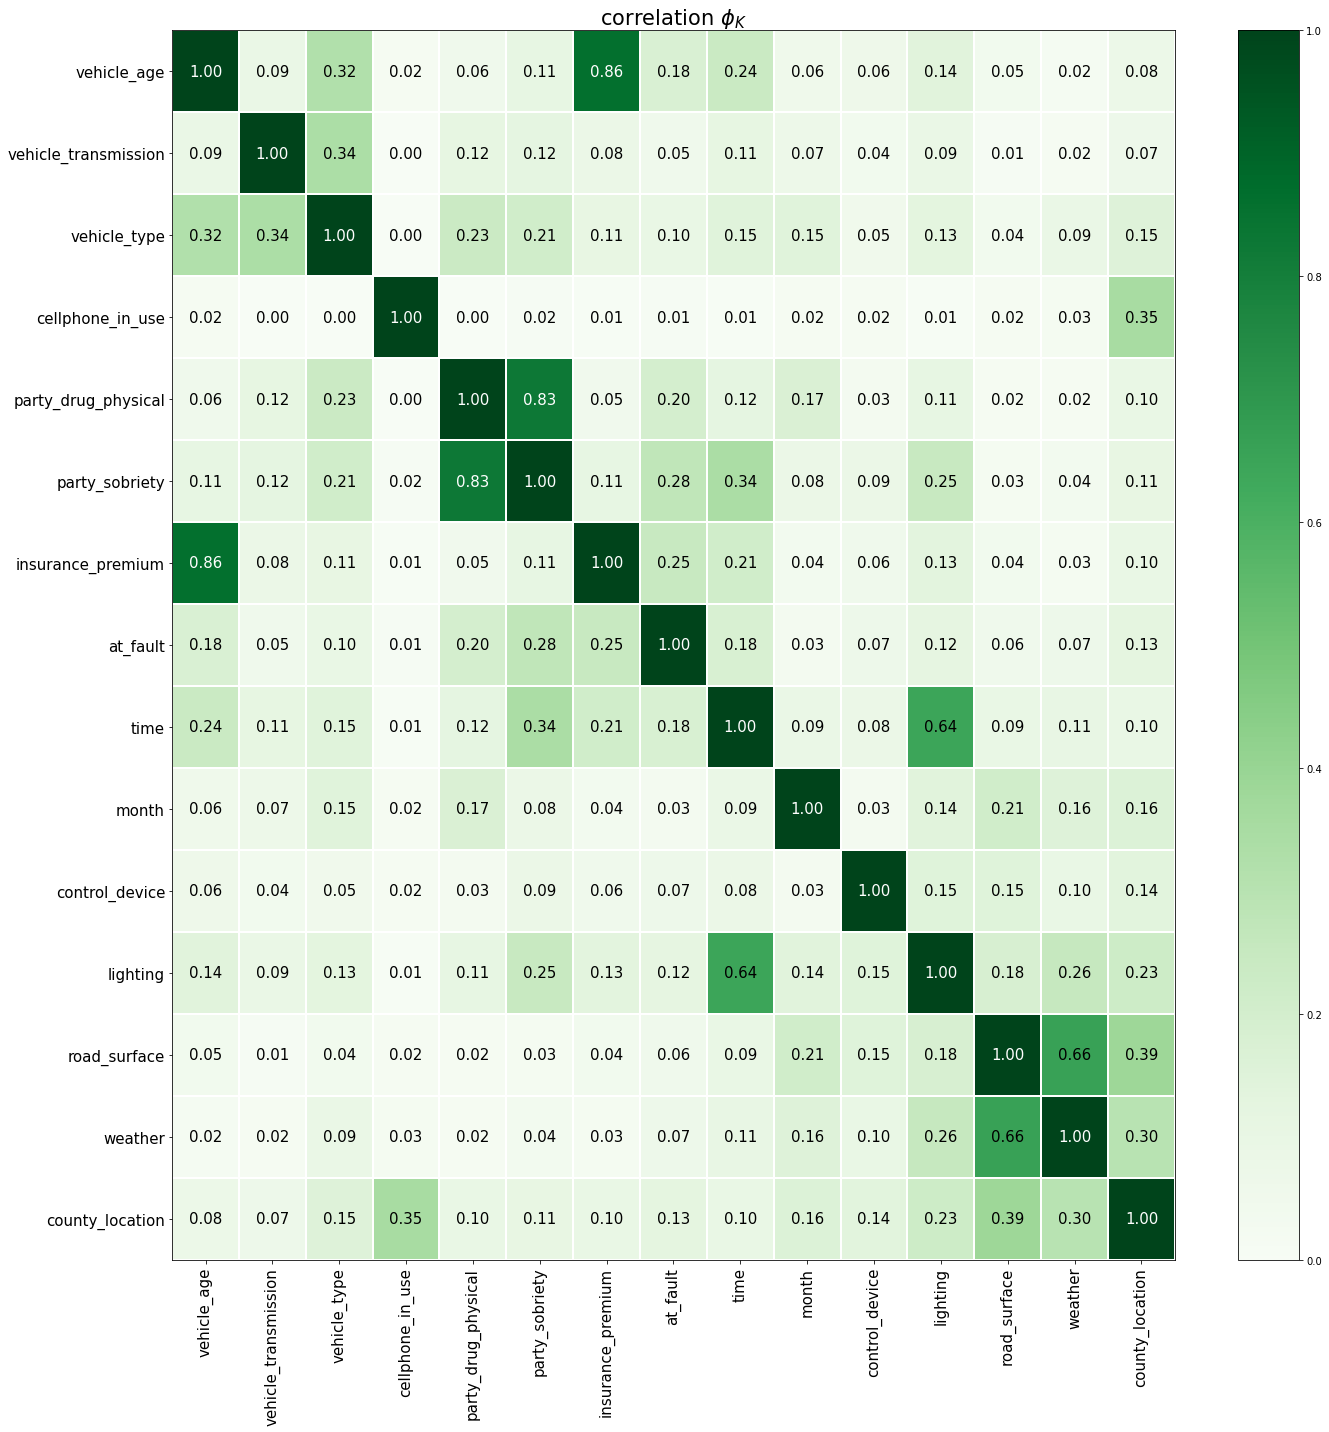

In [200]:
phic_matr = data.drop(['id', 'case_id', 'party_number'], axis=1).phik_matrix()
plot_correlation_matrix(phic_matr.values, 
                        x_labels=phic_matr.columns, 
                        y_labels=phic_matr.index, 
                        vmin=0, 
                        vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

Сильная корреляция у возраста автомобиля и суммы страховки, у признака влияние алкоголя и признака влияиние веществ на водителя.

Построим матрицу корреляции для целевого признака.

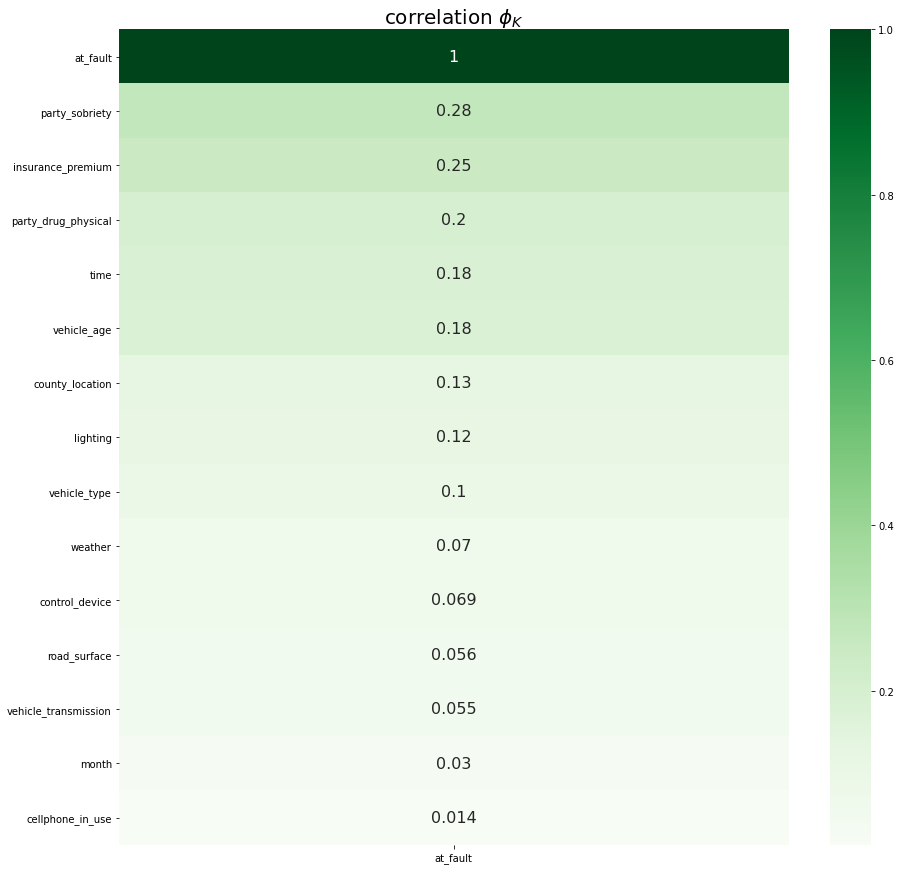

In [201]:
plt.figure(figsize=(15, 15))
sns.heatmap(phic_matr.sort_values(by = 'at_fault', ascending=False)[['at_fault']], 
            cmap='Greens', 
            annot=True, 
            annot_kws={'size':16}, 
            fmt='.2g')
plt.title(r"correlation $\phi_K$", fontsize=20)
plt.show()


Больше всего корреляция с целевым признаком у состояния водителя и суммой страховки.

Первичный отбор факторов:

- 'county_location' - географические районы могут влиять на стиль вождения водителя, что может сказываться на аварийности
- 'weather' - погодные условия напрямую оказывают влияние на аварийность (дорожное покрытие, видимость и т.д.)
- 'road_surface' - тип дорожного покрытия может влиять на аварийность, так как мокрая и заледеневшая дорога опаснее
- 'lighting' - освещенность влияет на видимость, плохая видимость повышает аварийность
- 'control_device' - средства управления могут помочь водителю избежать ДТП, поэтому этот признак влияет на аварийность
- 'month' - месяц влияет на аварийность, так как различные погодные условия могут ухудшить дорожные условия, видимость и т.д.
- 'time' - время суток влияет на аварийность, так как меняется видимость, меняется плотность потока машин и т.д.
- 'insurance_premium' - сумма страховки влияет на аккуратность вождения, что сказывается на аварийности
- 'party_sobriety' - алкогольное опьянение влияет на внимательность водителя, что может привести к аварии
- 'party_drug_physical' - вещества влияют на внимательность водителя, что может привести к аварии
- 'cellphone_in_use' - использования телефона по громкой связи может оказать влияние, так как телефон в руках водтеля может снизить его сконцентрированность на дороге
- 'vehicle_type' - тип автомобиля может влиять на аварийность, так как купе могут быть более мощыми и провоцировать их владельцев к нарушению ПДД, а владельцы седанов чаще возят пассажиров и могут быть из-за этого аккуратнее
- 'vehicle_transmission' - тип трансмиссии может влиять на аварийность, так как автомобили с автоматической трансмиссией проще в управлении и позволяют их владельцам больше сконцентрироваться на дороге
- 'vehicle_age' - возраст автомобиля может сказываться на его техническом состояние, которое влияет на возможность попадания в аварию

**Вывод:**

Были построены гистограммы для признаков из таблицы collisions и по ним были следующие выводы:

- В ясную погоду происходит больше всего аварий (вероятно, потому что в этих географических районах ясных дней больше всего).
- Больше всего аварий в сухую погоду (вероятно, потому что в этих географических районах ясных дней больше всего).
- Чаще всего аварии происходят при дневном свете (так как днем больше всего участников дорожного движения).
- Чаще всего попадают в ДТП автомобили, не оснащенные устройствами помощи водителю.
- Зимние и весенние месяцы наиболее аварийно-опасные (из-за нестабильных климатических условий и их последствий).
- Пик аварийности приходится на промежуток 14.00-18.00.
- Лос-Анджелес - самый аварийный город.

Были построены гистограммы для признаков из таблицы parties и vehicles в зависимости от целевого признака 'at_fault' и по ним были следующие выводы:

- Невыпившие водители чаще всего попадают в аварии, так как их больше всего на дорогах. Выпившие водители чаще всего становятся виновниками аварии.
- Водители под влиянием веществ чаще всего становятся виновниками аварии.
- Чаще всего водители попадают в аварии на седанах. Виновниками аварии чаще становятся водители купе в процентном соотношении от всех владельцев купе, владельцы седанов - более аккуратны.
- Автоматическая трансмиссия более безопасна.
- Чем больше страховка, тем аккуратнее водит автомобилист.
- Чем старше машина, тем аккуратнее водит водитель.

Целевой признак сбалансирован.

Была построена матрица коррелчции:
- Сильная корреляция у возраста автомобиля и суммы страховки, у признака влияние алкоголя и признака влияиние веществ на водителя.
- Больше всего корреляция с целевым признаком у состояния водителя и суммой страховки.

Был проведен первичный отбор факторов:

- 'county_location' - географические районы могут влиять на стиль вождения водителя, что может сказываться на аварийности
- 'weather' - погодные условия напрямую оказывают влияние на аварийность (дорожное покрытие, видимость и т.д.)
- 'road_surface' - тип дорожного покрытия может влиять на аварийность, так как мокрая и заледеневшая дорога опаснее
- 'lighting' - освещенность влияет на видимость, плохая видимость повышает аварийность
- 'control_device' - средства управления могут помочь водителю избежать ДТП, поэтому этот признак влияет на аварийность
- 'month' - месяц влияет на аварийность, так как различные погодные условия могут ухудшить дорожные условия, видимость и т.д.
- 'time' - время суток влияет на аварийность, так как меняется видимость, меняется плотность потока машин и т.д.
- 'insurance_premium' - сумма страховки влияет на аккуратность вождения, что сказывается на аварийности
- 'party_sobriety' - алкогольное опьянение влияет на внимательность водителя, что может привести к аварии
- 'party_drug_physical' - вещества влияют на внимательность водителя, что может привести к аварии
- 'cellphone_in_use' - использования телефона по громкой связи может оказать влияние, так как телефон в руках водтеля может снизить его сконцентрированность на дороге
- 'vehicle_type' - тип автомобиля может влиять на аварийность, так как купе могут быть более мощыми и провоцировать их владельцев к нарушению ПДД, а владельцы седанов чаще возят пассажиров и могут быть из-за этого аккуратнее
- 'vehicle_transmission' - тип трансмиссии может влиять на аварийность, так как автомобили с автоматической трансмиссией проще в управлении и позволяют их владельцам больше сконцентрироваться на дороге
- 'vehicle_age' - возраст автомобиля может сказываться на его техническом состояние, которое влияет на возможность попадания в аварию

### Отбор финального набора обучающих признаков

Разобьем датасет на обучающую и тестовую выборки.

In [202]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(columns=['id', 'case_id', 'party_number', 'at_fault'],axis=1), 
    data['at_fault'], 
    test_size=0.25, 
    shuffle=True,
    stratify=data['at_fault'],
    random_state=24)
print(features_train.shape)
print(features_test.shape)

(40118, 14)
(13373, 14)


Зададим категориальные и числовые признаки.

In [203]:
cat_columns = features_train.select_dtypes(include='object').columns
num_columns = features_train.select_dtypes(include='number').columns

При помощи pipeline и column_transformer соберем свой конвейер, включающий:
1. Для численных столбцов масштабирование данных при помощи StandardScaler().
2. Для категориальных столбцов кодирование данных при помощи OneHotEncoder().

In [204]:
num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
column_transformer = make_column_transformer((num_pipeline, num_columns),
                                             (cat_pipeline, cat_columns),
                                              remainder='passthrough')

**Вывод:**

Датасет был разбит на обучающую и тестовую выборки, были заданы категориальные и числовые признаки. При помощи pipeline и column_transformer был собран свой конвейер, включающий для численных столбцов масштабирование данных при помощи StandardScaler(), а для категориальных столбцов кодирование данных при помощи OneHotEncoder().

### Выбор и обучение моделей

В моделях будет рассматривать метрику f1, так как данная метрика подходит для задач бинарной классификации, она является гармонирческим средним между точностью (доля истинно положительных среди всех объектов, которые модель классифицировала как положительные) и полнотой (доля истинно положительных среди всех действительно положительных объектов).

Создадим словарь для лучших значений метрик различных моделей.

In [205]:
results = {}

Обучим модель LogisticRegression() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров solver, C и max_iter.

In [206]:
%%time
pipeline = make_pipeline(column_transformer,
                         LogisticRegression(random_state=13))
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
    'C': [0.0001, 0.001, 0.0002],
    'max_iter' : [500,1000]}
new_params = {'logisticregression__' + key: params[key] for key in params}
grid_imba_lr = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             verbose=1,
                             cv=3, 
                             scoring='f1', 
                             n_jobs=-1)
grid_imba_lr.fit(features_train, target_train)
print(grid_imba_lr.best_params_)
print(grid_imba_lr.best_score_)
results['LogisticRegression'] = [round(grid_imba_lr.best_score_,3)]

Fitting 3 folds for each of 30 candidates, totalling 90 fits
{'logisticregression__C': 0.0001, 'logisticregression__max_iter': 500, 'logisticregression__solver': 'newton-cg'}
0.6244268241163483
CPU times: user 1min 29s, sys: 31.9 s, total: 2min 1s
Wall time: 2min 1s


Модель LogisticRegression() при параметрах C = 0.001, solver = newton-cg и max_iter = 500 имеет наилучшую метрику f1, которая равняется 0,624 при кросс-валидации.

Обучим модель RandomForestClassifier() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров max_depth, max_features и n_estimators.

In [207]:
%%time
pipeline = make_pipeline(column_transformer,
                         RandomForestClassifier(random_state=13))
params = {
    'n_estimators': [100,150],
    'max_depth': [50,100],
    'max_features':[10,20]
    }
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba_rfc = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             verbose=1,
                             cv=3, 
                             scoring='f1', 
                             n_jobs=-1)
grid_imba_rfc.fit(features_train, target_train)
print(grid_imba_rfc.best_params_)
print(grid_imba_rfc.best_score_)
results['RandomForestClassifier'] = [round(grid_imba_rfc.best_score_,3)]

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 20, 'randomforestclassifier__n_estimators': 150}
0.6117277457105111
CPU times: user 2min 58s, sys: 458 ms, total: 2min 58s
Wall time: 2min 58s


Модель RandomForestClassifier() при параметре n_estimators равному 150, параметре  max_depth равному 100 и параметре max_features равному 20 имеет наилучшую метрику f1, которая равняется 0,612.

Обучим модель CatBoostClassifier() при использования поиска по сетке при помощи GridSearchCV() с перебором параметров n_estimators, depth и learning_rate.

In [208]:
%%time
pipeline = make_pipeline(column_transformer,
                         CatBoostClassifier(random_state=13))
params = {'depth'         : [2,4,6],
          'learning_rate' : [0.01,0.1,0.5],
          'n_estimators'    : [500,1000]
         }
new_params = {'catboostclassifier__' + key: params[key] for key in params}
grid_imba_cbc = GridSearchCV(pipeline, 
                             param_grid=new_params,
                             cv=2, 
                             scoring='f1_micro',
                             verbose=2,
                             n_jobs=-1)
grid_imba_cbc.fit(features_train, target_train)
print(grid_imba_cbc.best_params_)
print(grid_imba_cbc.best_score_)
results['CatBoostClassifier'] = [round(grid_imba_cbc.best_score_,3)]

Fitting 2 folds for each of 18 candidates, totalling 36 fits
0:	learn: 0.6919622	total: 4.54ms	remaining: 2.27s
1:	learn: 0.6907788	total: 8.19ms	remaining: 2.04s
2:	learn: 0.6895016	total: 12.2ms	remaining: 2.02s
3:	learn: 0.6883888	total: 15.8ms	remaining: 1.96s
4:	learn: 0.6871635	total: 19.5ms	remaining: 1.93s
5:	learn: 0.6860992	total: 23.1ms	remaining: 1.9s
6:	learn: 0.6850267	total: 26.9ms	remaining: 1.89s
7:	learn: 0.6839825	total: 30.8ms	remaining: 1.89s
8:	learn: 0.6829753	total: 34.2ms	remaining: 1.87s
9:	learn: 0.6819819	total: 37.6ms	remaining: 1.84s
10:	learn: 0.6810370	total: 41.1ms	remaining: 1.82s
11:	learn: 0.6802243	total: 44.8ms	remaining: 1.82s
12:	learn: 0.6793551	total: 48ms	remaining: 1.8s
13:	learn: 0.6784169	total: 51.7ms	remaining: 1.79s
14:	learn: 0.6775166	total: 55.5ms	remaining: 1.79s
15:	learn: 0.6764956	total: 59.2ms	remaining: 1.79s
16:	learn: 0.6754704	total: 63ms	remaining: 1.79s
17:	learn: 0.6746323	total: 66.7ms	remaining: 1.78s
18:	learn: 0.673798

Модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665.

Построим таблицу с метриками всех рассмоторенных моделей.

In [209]:
pd.DataFrame(results, index=['f1']).transpose()

,f1
LogisticRegression,0.624
RandomForestClassifier,0.612
CatBoostClassifier,0.665


Обучим на тестовой выборке наилучшую модель - CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01.

In [210]:
predictions_test_cbc = grid_imba_cbc.predict(features_test)
cr = classification_report(target_test, 
                      predictions_test_cbc,
                      output_dict=True, 
                      zero_division=0)
pd.DataFrame(cr).round(decimals=3).transpose()

,precision,recall,f1-score,support
0,0.634,0.736,0.681,6651.000
1,0.689,0.580,0.630,6722.000
accuracy,0.657,0.657,0.657,0.657
macro avg,0.662,0.658,0.655,13373.000
weighted avg,0.662,0.657,0.655,13373.000


Вывод:

Были обучены модели LogisticRegression(), RandomForestClassifier() и CatBoostClassifier() при использования поиска по сетке при помощи GridSearchCV().

В моделях была рассмотрена метрика f1, так как данная метрика подходит для задач бинарной классификации, она является гармоническим средним между точностью (доля истинно положительных среди всех объектов, которые модель классифицировала как положительные) и полнотой (доля истинно положительных среди всех действительно положительных объектов).

- Модель LogisticRegression() при параметрах C = 0.001, solver = newton-cg и max_iter = 500 имеет наилучшую метрику f1, которая равняется 0,624 при кросс-валидации.
- Модель RandomForestClassifier() при параметре n_estimators равному 150, параметре max_depth равному 100 и параметре max_features равному 20 имеет наилучшую метрику f1, которая равняется 0,612.
- Модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665.

Наилучшей является модель Модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665 на трейне при кросс-валидации и 0.665 на тесте.

## Проведите анализ важности факторов ДТП

Построим матрицу ошибок.

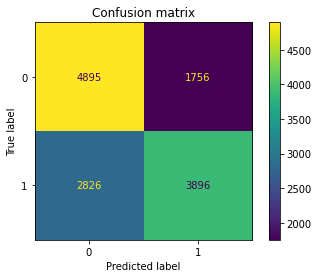

In [211]:
conf_matrix = confusion_matrix(target_test, predictions_test_cbc)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=grid_imba_cbc.classes_)
vis.plot()
plt.title('Confusion matrix');
plt.show();

- Прогноз совпал с реальностью для 0 для 4895 значения, а для 1 - для 3896 значений. 
- Модель предсказала 0, а на самом деле должно быть 1 для 2826 значений.
- Модель предсказала 1, а на самом деле должно быть 0 для 1756 значений.

Построим график полнота - точность.

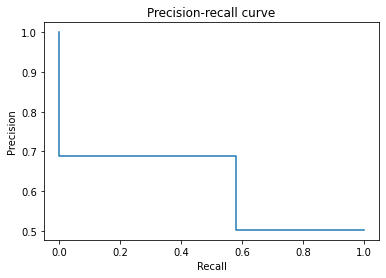

In [212]:
prec, recall, _ = precision_recall_curve(target_test, predictions_test_cbc)
vis = PrecisionRecallDisplay(prec, recall)
vis.plot()
plt.title('Precision-recall curve');
plt.show();

Проведем анализ важности признаков наилучшей модели при помощи permutation_importance().

In [213]:
importance = permutation_importance(grid_imba_cbc, features_train, target_train, scoring='f1')

Построим график важности признаков.

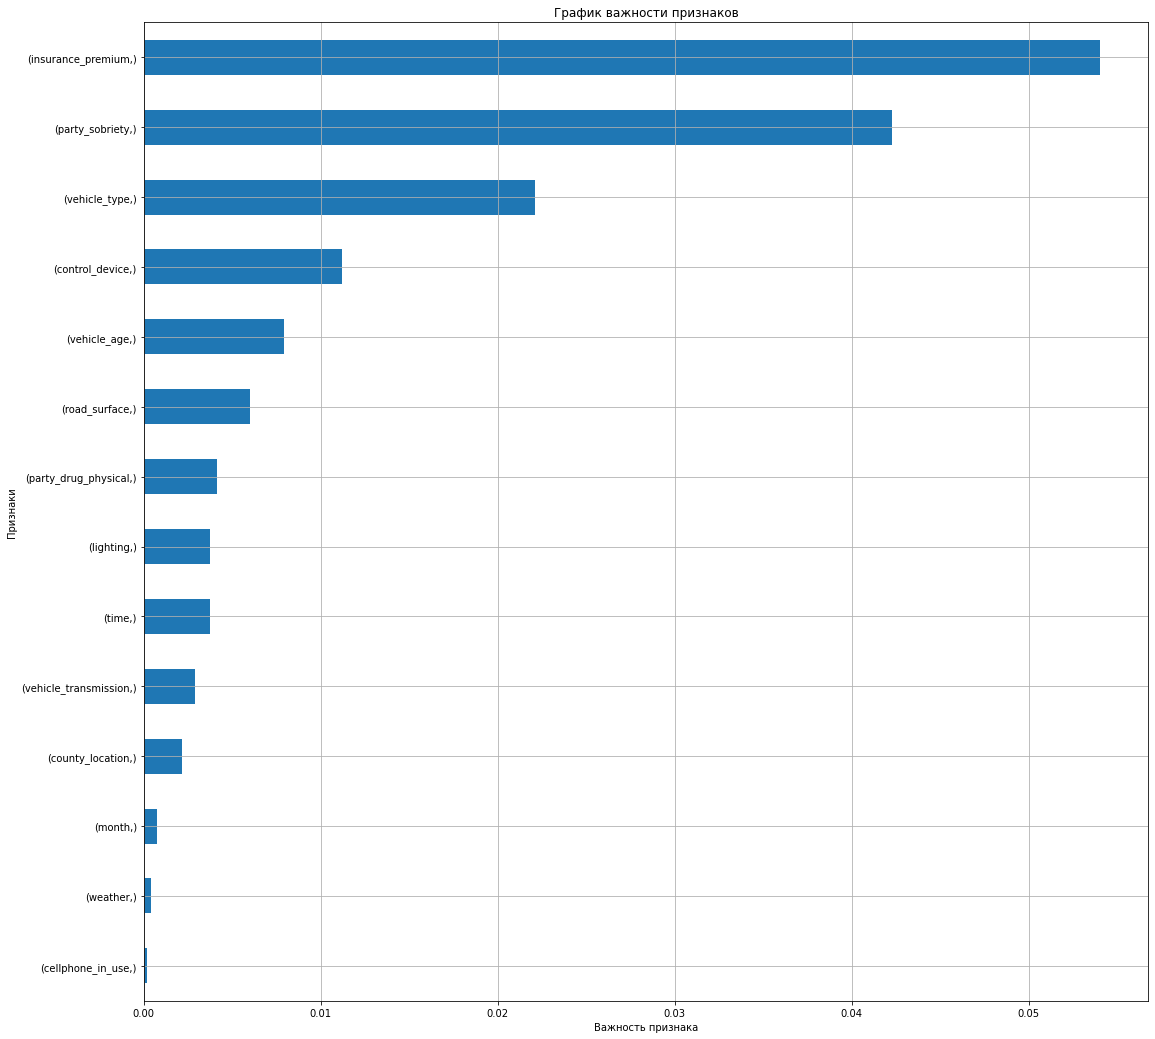

In [214]:
_ = (pd.Series(importance.importances_mean, index=[features_train.columns])
        .sort_values(ascending=True)
        .plot(kind="barh", 
              figsize=(18,18), 
              grid=True, 
              title='График важности признаков'))
plt.xlabel('Важность признака');
plt.ylabel('Признаки');

Наиболее важные признаки для модели:
- сумма страховки
- трезвость водителя
- тип трансмиссии
- наличие устройства помощи водителю
- возраст автомобиля

Исследуем зависимость возраста автомобиля от виновности водителя.

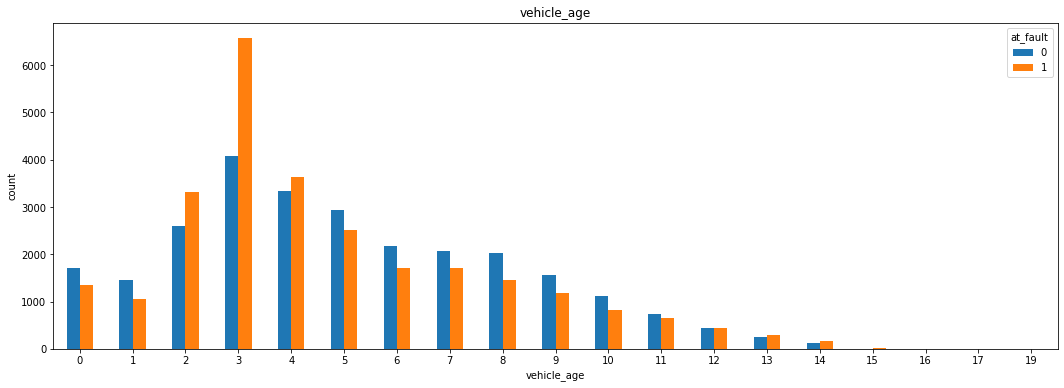

In [215]:
data.pivot_table('id', 'vehicle_age', 'at_fault', aggfunc='count').plot(kind='bar', figsize=(18,6), rot=0);
plt.title('vehicle_age');
plt.xlabel('vehicle_age');
plt.ylabel('count');
plt.show();

Виновниками аварии чаще становятся владельцы машин возраста 2-4 года.

Для того, чтобы снизить уровень аварийности можно предложить проходить владельцам таких автомобилей дополнительную проверку на знание ПДД перед посадкой, а также можно повысить сумму штрафа для них при попадании в ДТП.

**Вывод:**

Была построена матрица ошибок и кривая зависимости полноты и точности:
- Прогноз совпал с реальностью для 0 для 5032 значения, а для 1 - для 3878 значений. 
- Модель предсказала 0, а на самом деле должно быть 1 для 2844 значений.
- Модель предсказала 1, а на самом деле должно быть 0 для 1619 значений.

Наиболее важные признаки для модели:
- сумма страховки
- трезвость водителя
- тип трансмиссии
- наличие устройства помощи водителю
- возраст автомобиля

Было проведено исследование одного из важных факторов, влияющих на аварийность:
- Виновниками аварии чаще становятся владельцы машин возраста 2-4 года. Для того, чтобы снизить уровень аварийности можно предложить проходить владельцам таких автомобилей дополнительную проверку на знание ПДД перед посадкой, а также можно повысить сумму штрафа для них при попадании в ДТП.

## Выводы

**Описание**

В данном проекте для каршеринговой компании была неоходимо понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

**Подключение к базе**

Была написана конфигурация для подключения к базе данных data-science-vehicle-db, в которой содержатся таблицы, необходимые для работы, а также создано подключение.

**Первичное исследование таблиц**

Были выгружены таблицы collisions, parties, vehicles.

- Все таблицы имеют набор данных, соответсвующий приведенному описанию.
- Количество таблиц соответсвует заявленному.
- Общим ключом для связи является case_id и он имеется во всех таблицах.

**Статистический анализ факторов ДТП**

Были подготовлены задачи для рабочей группы:

- Выяснить в какой месяц чаще всего происходят аварии.
- Определить количество аварий в зависимости от времени суток и освещенности дороги (collisions).
- Определить самую аварийно-опасную погоду (collisions).
- Провести анализ серьезности происшествия в зависимости от погодных условий и состояния дороги (collisions).
- Определить количество аварий в зависимости от географического района (collisions).
- Определить количество аварий в зависимости от типа дороги (collisions).
- Провести анализ количества участников ДТП в зависимости от погодных условий и состояния дороги (collisions).
- Определить какой тип нарушения ПДД приводит чаще всего к ДТП (collisions).
- Определить тип аварии в зависимости от типа дороги (collisions).
- Определить самый часто встречающийся тип участника ДТП (parties).
- Определить разброс количества участников ДТП (parties). 
- Провести анализ серьезности происшествия в зависимости от состояния и трезвости водителя (collisions и parties).
- Провести анализ зависимости причины аварии от состояния и трезвости водителя (collisions и parties).
- Определить влияние наличия телефона в автомобиле на тип аварии (collisions и parties).
- Провести анализ серьезности происшествия в зависимости от возраста автомобиля (collisions и vehicles).

Некоторые из пунктов были проверены:

- Самое большое количество аварий происходит в октябре, декабре и марте (вероятнее всего это происходит из-за сложных погодных условий). Меньше всего аварий происходит в июне.
- Автомобили как со встроенным телефоном, так и без него чаще всего поподают в аварии типа "столкновение задней частью". Виновники аварии чаще всего не имеют встроенного телефона в машине, а это значит, что они могут пользоваться телефоном в руке и отвлекаться от дороги, что повышает аварийность.
- Чем старше автомобиль, тем повреждения, нанесенные в аварии, опаснее.

**Модель для оценки водительского риска**

**Выгрузка данных для модели**

Были выгружены данные из таблиц collisions, parties и vehicles при следующих условиях:

- Тип виновника — только машина (car).  
- ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина). 
- Данные выбраны только за 2012 год.

**Предобработка**

- Были выявлены пропуски в данных:
  - Пропуски по приведенному описанию данных для категориальных столбцов 'weather', 'road_surface', 'lighting', 'control_device', 'party_sobriety', 'party_drug_physical', 'vehicle_transmission' соотвествуют значению 'not_stated'. Были заменены все пропуски в этих столбцах на 'not_stated'.
  - Пропуски в численном столбце 'cellphone_in_use' были заменены на 0.
  - Пропуски в численных столбцах 'time', 'insurance_premium' и 'vehicle_age' были удалены.
- В столбце party_drug_physical заменили значение G на расшифровку - impairment unknown.
- Заменили типы столбцов 'case_id', 'month', 'time', 'insurance_premium' и 'vehicle_age'' на целочисленный.
- В столбце 'vehicle_age' встречались аномалии, они были удалены. Выбросы выявлены не были.
- Неявных дубликатов не было найдено, а явные были выявлены и удалены.

**Исследовательский анализ**

Были построены гистограммы для признаков из таблицы collisions и по ним были следующие выводы:

- В ясную погоду происходит больше всего аварий (вероятно, потому что в этих географических районах ясных дней больше всего).
- Больше всего аварий в сухую погоду (вероятно, потому что в этих географических районах ясных дней больше всего).
- Чаще всего аварии происходят при дневном свете (так как днем больше всего участников дорожного движения).
- Чаще всего попадают в ДТП автомобили, не оснащенные устройствами помощи водителю.
- Зимние и весенние месяцы наиболее аварийно-опасные (из-за нестабильных климатических условий и их последствий).
- Пик аварийности приходится на промежуток 14.00-18.00.
- Лос-Анджелес - самый аварийный город.

Были построены гистограммы для признаков из таблицы parties и vehicles в зависимости от целевого признака 'at_fault' и по ним были следующие выводы:

- Невыпившие водители чаще всего попадают в аварии, так как их больше всего на дорогах. Выпившие водители чаще всего становятся виновниками аварии.
- Водители под влиянием веществ чаще всего становятся виновниками аварии.
- Чаще всего водители попадают в аварии на седанах. Виновниками аварии чаще становятся водители купе в процентном соотношении от всех владельцев купе, владельцы седанов - более аккуратны.
- Автоматическая трансмиссия более безопасна.
- Чем больше страховка, тем аккуратнее водит автомобилист.
- Чем старше машина, тем аккуратнее водит водитель.

Целевой признак сбалансирован.

Была построена матрица коррелчции:
- Сильная корреляция у возраста автомобиля и суммы страховки, у признака влияние алкоголя и признака влияиние веществ на водителя.
- Больше всего корреляция с целевым признаком у состояния водителя и суммой страховки.

Был проведен первичный отбор факторов:

- 'county_location' - географические районы могут влиять на стиль вождения водителя, что может сказываться на аварийности
- 'weather' - погодные условия напрямую оказывают влияние на аварийность (дорожное покрытие, видимость и т.д.)
- 'road_surface' - тип дорожного покрытия может влиять на аварийность, так как мокрая и заледеневшая дорога опаснее
- 'lighting' - освещенность влияет на видимость, плохая видимость повышает аварийность
- 'control_device' - средства управления могут помочь водителю избежать ДТП, поэтому этот признак влияет на аварийность
- 'month' - месяц влияет на аварийность, так как различные погодные условия могут ухудшить дорожные условия, видимость и т.д.
- 'time' - время суток влияет на аварийность, так как меняется видимость, меняется плотность потока машин и т.д.
- 'insurance_premium' - сумма страховки влияет на аккуратность вождения, что сказывается на аварийности
- 'party_sobriety' - алкогольное опьянение влияет на внимательность водителя, что может привести к аварии
- 'party_drug_physical' - вещества влияют на внимательность водителя, что может привести к аварии
- 'cellphone_in_use' - использования телефона по громкой связи может оказать влияние, так как телефон в руках водтеля может снизить его сконцентрированность на дороге
- 'vehicle_type' - тип автомобиля может влиять на аварийность, так как купе могут быть более мощыми и провоцировать их владельцев к нарушению ПДД, а владельцы седанов чаще возят пассажиров и могут быть из-за этого аккуратнее
- 'vehicle_transmission' - тип трансмиссии может влиять на аварийность, так как автомобили с автоматической трансмиссией проще в управлении и позволяют их владельцам больше сконцентрироваться на дороге
- 'vehicle_age' - возраст автомобиля может сказываться на его техническом состояние, которое влияет на возможность попадания в аварию

**Отбор финального набора обучающих признаков**

Датасет был разбит на обучающую и тестовую выборки, были заданы категориальные и числовые признаки. При помощи pipeline и column_transformer был собран свой конвейер, включающий для численных столбцов масштабирование данных при помощи StandardScaler(), а для категориальных столбцов кодирование данных при помощи OneHotEncoder().

**Выбор и обучение моделей**

Были обучены модели LogisticRegression(), RandomForestClassifier() и CatBoostClassifier() при использования поиска по сетке при помощи GridSearchCV().

В моделях была рассмотрена метрика f1, так как данная метрика подходит для задач бинарной классификации, она является гармоническим средним между точностью (доля истинно положительных среди всех объектов, которые модель классифицировала как положительные) и полнотой (доля истинно положительных среди всех действительно положительных объектов).

- Модель LogisticRegression() при параметрах C = 0.001, solver = newton-cg и max_iter = 500 имеет наилучшую метрику f1, которая равняется 0,624 при кросс-валидации.
- Модель RandomForestClassifier() при параметре n_estimators равному 150, параметре max_depth равному 100 и параметре max_features равному 20 имеет наилучшую метрику f1, которая равняется 0,612.
- Модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665.

Наилучшей является модель Модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665 на трейне при кросс-валидации и 0.665 на тесте.

**Анализ важности факторов ДТП**

Была построена матрица ошибок и кривая зависимости полноты и точности:
- Прогноз совпал с реальностью для 0 для 4895 значения, а для 1 - для 3896 значений. 
- Модель предсказала 0, а на самом деле должно быть 1 для 2826 значений.
- Модель предсказала 1, а на самом деле должно быть 0 для 1756 значений.

Наиболее важные признаки для модели:
- сумма страховки
- трезвость водителя
- тип трансмиссии
- наличие устройства помощи водителю
- возраст автомобиля

Было проведено исследование одного из важных факторов, влияющих на аварийность:
- Виновниками аварии чаще становятся владельцы машин возраста 2-4 года. Для того, чтобы снизить уровень аварийности можно предложить проходить владельцам таких автомобилей дополнительную проверку на знание ПДД перед посадкой, а также можно повысить сумму штрафа для них при попадании в ДТП.

**Рекомендации и общий вывод**

- Наилучшей является модель модель CatBoostClassifier() при параметре n_estimators равному 1000, параметре depth равному 4 и параметре learning_rate равному 0,01 имеет наилучшую метрику f1, которая равняется 0,665 на трейне при кросс-валидации и 0.665 на тесте.
- Создание адекватной системы оценки риска при выдаче автомобиля возможно, метрики наилучшей модели получились достаточно высокими, для лучшей оценки риска при выдаче автомобиля необходимо собирать больше данных.
- Чтобы улучшить модель можно:
  - уточнить данные водителя: опыт вождения, пол, возраст, участие в ДТП в прошлом и т.д.
  - уточнить данные предполагаемого маршрута у водителя для диагностирования опасных дорожных участков
  - сигнализировать водителю о факторах, влияющих на условия вождения: плохие погодные условия, плохие дорожные условия, освещенность
  - поставаить дополнительное оборудование (камеры, анализаторы алкольного опьянения и т.д) для диагностирования состояния водителя